In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [23]:
pairing='mindiag'
treekwargs = dict(
    use_gen=False,
    normalization=None,
)

base = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/trg/btagfix/skim_20231001'

f_pattern = '{base}/{pairing}_sig_2018_0L/mc/ggHH4b_tree.root'
f_sig = f_pattern.format(base=base, pairing='mindiag')
private_runs = ObjIter([Tree( fourb.nanohh4b.get_local_alt(f_sig), treename='Runs', **treekwargs, sample='private ggHH4b')])
private_signal = ObjIter([Tree( fourb.nanohh4b.get_local_alt(f_sig), treename='Events', **treekwargs, sample='private ggHH4b')])

base = '/eos/user/m/mkolosov/Run2_HHTo4B_NTuples/UL2018/BugFix_UL2018_2018_0L'

f_pattern = '{base}/mc/ggHH4b_tree.root'
f_sig = f_pattern.format(base=base)
central_runs = ObjIter([Tree( fourb.nanohh4b.get_local_alt(f_sig), treename='Runs', **treekwargs, sample='central ggHH4b')])
central_signal = ObjIter([Tree( fourb.nanohh4b.get_local_alt(f_sig), treename='Events', **treekwargs, sample='central ggHH4b')])



# f_pattern = '{base}/data/jetht_tree.root'
# f_data = f_pattern.format(base=base)

# data = ObjIter([Tree( fourb.nanohh4b.get_local_alt(f_data), **dict(treekwargs, normalization=None, color='black'))])

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


In [41]:
gensumw = (private_runs + central_runs).genEventCount.apply(sum).npy
nevents = (private_signal + central_signal).apply(len).npy
nevents/(gensumw)

array([0.13182075, 0.135004  ])

In [43]:
gensumw = (private_runs + central_runs).genEventSumw.apply(sum).npy
nevents = (private_signal + central_signal).genWeight.apply(sum).npy
nevents/(gensumw)

array([0.08877875, 0.1219806 ])

In [40]:
(private_signal + central_signal).apply(lambda t : np.mean(t.genWeight))

[0.025483517302209123, 0.025488972780436134]

array([0.13182075, 0.135004  ])

In [3]:
(private_signal + central_signal).apply(lambda t : t.reweight(t.genWeight * t.xsecWeight * t.puWeight / 1000))

[None, None]

100%|██████████| 4/4 [00:00<00:00, 10.04it/s]


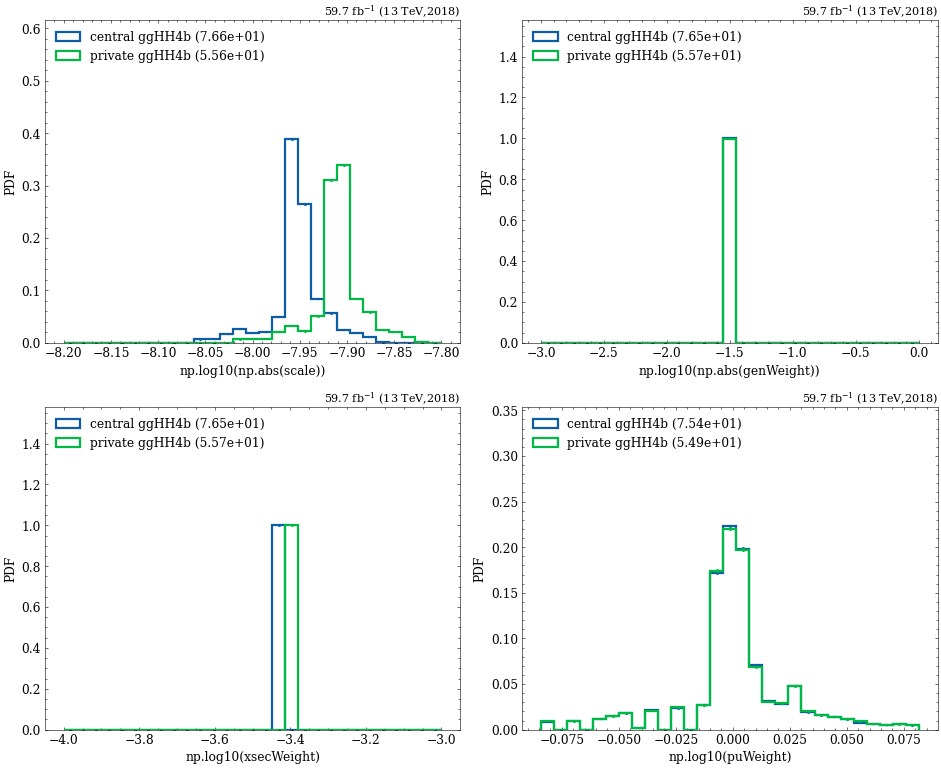

In [19]:
study.quick(
    central_signal + private_signal,
    varlist=['np.log10(np.abs(scale))','np.log10(np.abs(genWeight))','np.log10(xsecWeight)','np.log10(puWeight)'],
    binlist=[(-8.2,-7.8,30), (-3, 0, 30), (-4, -3, 30)],
   legend=True, efficiency=True,
)

In [29]:
np.sqrt(np.sum(cs**2)) , np.sqrt(np.sum(ps**2))

(0.24473292334957591, 0.21992787576806416)

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


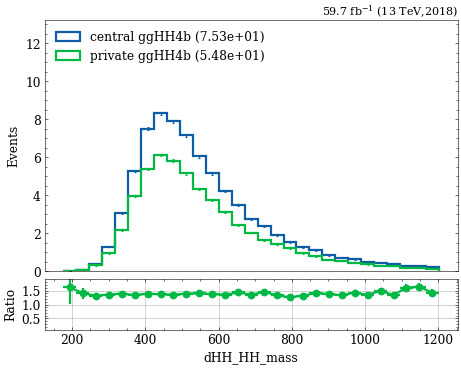

In [38]:
study.quick(
    central_signal + private_signal,
    varlist=['dHH_HH_mass'],
    legend=True,
    ratio=True,
    # efficiency=True,
)

In [4]:
signal = signal.subset(fraction=0.5, randomize=False)
data = data.subset(fraction=0.5, randomize=False)

In [5]:
signal = signal.apply(EventFilter('exactly_4btag', filter=lambda t: fourb.nanohh4b.n_medium_btag(t) == 4))
bkg = data.apply(EventFilter('exactly_3btag', filter=lambda t: fourb.nanohh4b.n_medium_btag(t) == 3))
bkg = bkg.asmodel()

In [6]:
bdt_features = [
    'ak4_h1b1_regpt', 'ak4_h1b2_regpt', 'ak4_h2b1_regpt', 'ak4_h2b2_regpt',
    'dHH_H1_regmass', 'dHH_H2_regmass', 'dHH_H1_pt', 'dHH_H2_pt', 
    'dHH_HH_mass', 'dHH_HH_pt','dHH_SumRegPtb', 'dHH_SumRegResb',
    'dHH_H1b1_H1b2_deltaR', 'dHH_H2b1_H2b2_deltaR', 'dHH_H1_H2_deltaEta','dHH_mindRbb', 
    'dHH_maxdEtabb','dHH_absCosTheta_H1_inHHcm', 'dHH_absCosTheta_H1b1_inH1cm', 'dHH_NbtagT',
]

bdt = KFoldBDTClassifier(
    features=bdt_features,
    kfold=2,
)

In [7]:
bdt.train(bkg, signal)
bdt.print_results(bkg, signal)

KeyboardInterrupt: 

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


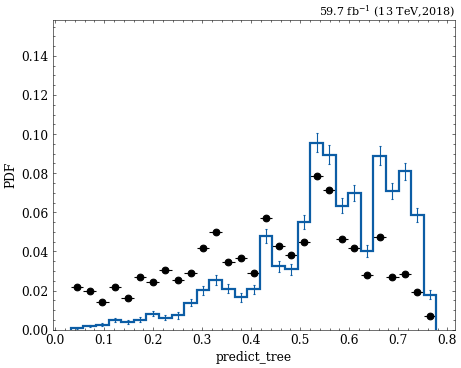

In [22]:
study.quick(
    signal + bkg,
    varlist=[bdt.predict_tree],
    efficiency=True,
)